In [1]:
# installing the reqs
!pip install ultralytics
!pip install torch torchvision torchaudio --upgrade
!pip install datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 147.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39

In [2]:
# All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os, time
from datasets import load_from_disk
import json
import shutil
from google.colab import files

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


dataset = load_from_disk("/content/drive/MyDrive/COMP9517/hf_dataset")
print(dataset)
### This is how the dataset looks like

DatasetDict

    train: Dataset({
            features: ['image', 'objects'],
            num_rows: 11502
        })

    validation: Dataset({
        features: ['image', 'objects'],
        num_rows: 1095
    })

    test: Dataset({
        features: ['image', 'objects'],
        num_rows: 546
    })})

In [8]:
model = YOLO("/content/drive/MyDrive/COMP9517/yolo12n.pt") # loading the model locally the version of ultralytics available on colab doesnt have yolov12

# print("loaded yolo model:", model)


In [ ]:
# First upload the kaggle_data.rar file to colab then run this code to load the data in the VM for faster training loading from drive takes a lot of time
!apt-get install -y unrar
!mkdir -p /content/dataset # not necessary still failsafe
# extract the file
!unrar x -y /content/kaggle_data.rar /content/dataset/
# output cleared for now


In [10]:
# Writing my own data.yaml with custom paths
%%writefile data.yaml
train: /content/dataset/kaggle_data/train/images
val: /content/dataset/kaggle_data/valid/images
test: /content/dataset/kaggle_data/test/images

nc: 12

names:
  - Ants
  - Bees
  - Beetles
  - Caterpillars
  - Earthworms
  - Earwigs
  - Grasshoppers
  - Moths
  - Slugs
  - Snails
  - Wasps
  - Weevils


Writing data.yaml


### **Pre-processing**

All the images were already of the same size, ultralytics internally takes care of normalizing the pixel values, converting BGR to RGB and also applies some data augmentations by default such as random horizontal flip, HSV shifts, translation and most importantly mosaic

### Mosaic
The key idea is that before the images are placed into the four mosaic quadrants, each image is randomly scaled (resized) — sometimes bigger, sometimes smaller then cropped to fit into the mosaic.

Mosaic automatically reduces later in training

YOLO has a built in scheduler:

1.   Early epochs: Mosaic = ON (strong augmentation)
2.   As we go from MId to late epochs: Mosaic gradually reduces to near OFF
3.   Last few epochs: No mosaic (model fine-tunes on real images)

In summary,
This helps the model avoid, overfitting early and unstable convergence late also we dont need to do this manually YOLO does it automatically

In [11]:
# Train YOLOv12n with early stopping
model.train(
    data="data.yaml",
    epochs = 50,
    imgsz = 640, # all the images are 640 * 640 for our data
    batch =16,
    project="my_yolo_experiment", # store logs, plots, and weights at this dir /content/my_yolo_experiment/run_1/
    name = "run_1",
    exist_ok =True,
    patience=5)
# by default the best model will be saved when using early stopping

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/COMP9517/yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7c380b2660>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,  

In [16]:
# Evaluate best model
best_model_path = "/content/my_yolo_experiment/run_1/weights/best.pt"
best_model =YOLO(best_model_path)
results =  best_model.val(data="data.yaml",split="test")

# global summary metrics converting to float
test_metrics = {"precision_mean": float(results.box.mp),
    "recall_mean": float(results.box.mr) ,
    "mAP50_mean":float(results.box.map50),
    "mAP50-95_mean":float(results.box.map) ,
    "fitness": float(results.fitness)}

# per-class summary processing to save appropriately
per_class_summary_raw =  results.summary()  # list of dicts
per_class_summary =[]

for entry in per_class_summary_raw:
    clean_entry = {key:(float(val) if isinstance(val,(np.floating,np.integer)) else val)

                   for key,val in entry.items()}
    per_class_summary.append(clean_entry)

# saving to json dump
output_metrics_path = "/content/test_metrics_full.json"
with open(output_metrics_path,"w") as f:
    json.dump({"global_metrics": test_metrics,
        "per_class_metrics":per_class_summary},
              f,indent=4)

print("Full test metrics saved to: ",output_metrics_path)


Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12n summary (fused): 159 layers, 2,559,068 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1281.1±45.9 MB/s, size: 39.2 KB)
val: Scanning /content/dataset/kaggle_data/test/labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 1.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 9.2it/s 3.8s
                   all        546        689      0.824      0.756      0.795      0.481
                  Ants         54         87       0.86      0.778      0.792      0.332
                  Bees         40         44      0.834      0.909      0.877      0.476
               Beetles         41         44      0.689      0.727      0.734      0.391
          Caterpillars         46         93      0.722      0.503      0.671      0.365
            Earthworms 

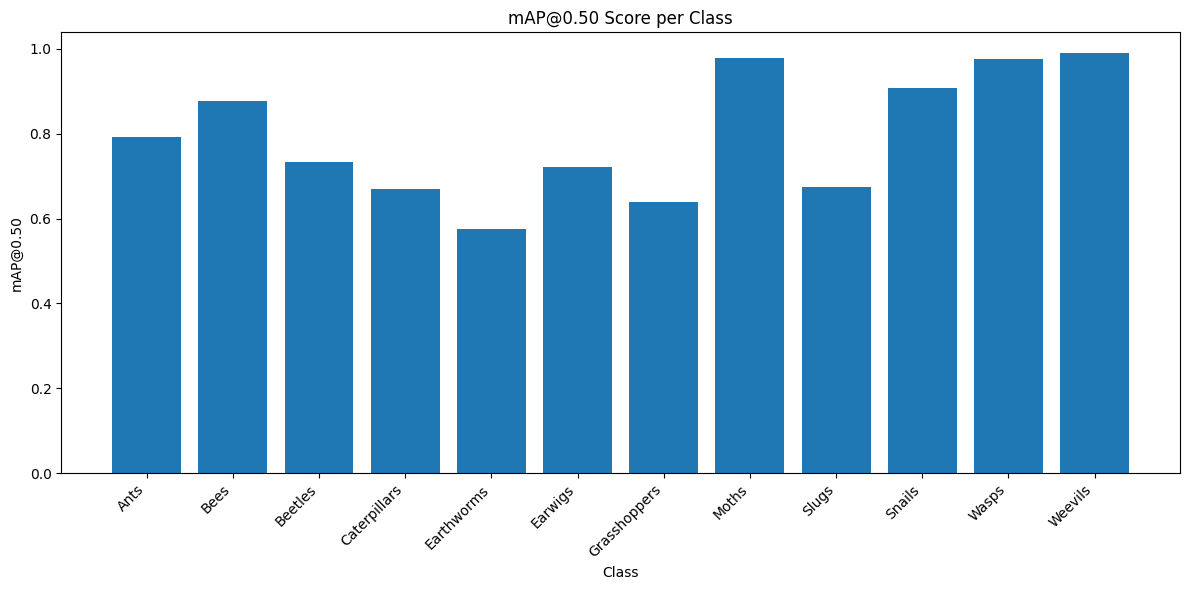

saved bar chart: /content/mAP50_per_class.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

download started 

Included:
- Training logs & charts
- best_model.pt
- test_metrics.json
- per_class_metrics.csv
- mAP50_per_class.png


In [17]:
# converting metrics to a csv
df = pd.DataFrame(per_class_summary)
csv_path = "/content/per_class_metrics.csv"
df.to_csv(csv_path, index=False)

#bar charts for mAP50 for each class
plt.figure(figsize=(12,6))
plt.bar(df['Class'],df['mAP50'])
plt.xlabel("Class")
plt.ylabel("mAP@0.50")
plt.title("mAP@0.50 Score per Class")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()

chart_path = "/content/mAP50_per_class.png"
plt.savefig(chart_path)
plt.show()
print("saved bar chart:", chart_path)

# Putting everything in one folder
package_dir ="/content/yolo_results_package"

if os.path.exists(package_dir):
    shutil.rmtree(package_dir)
os.makedirs(package_dir)

# training results
shutil.copytree("/content/my_yolo_experiment/run_1", f"{package_dir}/training_results")

# the best model
shutil.copy("/content/my_yolo_experiment/run_1/weights/best.pt", f"{package_dir}/best_model.pt")

# test metrics in json format
shutil.copy(output_metrics_path, f"{package_dir}/test_metrics.json")
# the csv and chart
shutil.copy(csv_path,f"{package_dir}/per_class_metrics.csv")
shutil.copy(chart_path,f"{package_dir}/mAP50_per_class.png")

# zip everything together to download it automatically after model has been trained
zip_path = "/content/yolo_results_package.zip"
shutil.make_archive("/content/yolo_results_package",'zip',package_dir)
files.download(zip_path)

print("download started \n")
print("Included:\n- Training logs & charts\n- best_model.pt\n- test_metrics.json\n- per_class_metrics.csv\n- mAP50_per_class.png")
